In [20]:
import proplot as pplt
import fitsio
import numpy as np
import des_y6utils.mdet
import ngmix
import scipy.interpolate

In [2]:
def _compute_r(d, msk=None, w=None):
    if msk is None:
        msk = np.ones_like(d["wmom_g_1"]).astype(bool)
        
    if w is None:
        w = np.ones_like(d["wmom_g_1"])
        
    msk_1p = msk & (d["mdet_step"] == "1p")
    nrm = np.sum(w[msk_1p])    
    e1_1p = np.sum(w[msk_1p] * d["wmom_g_1"][msk_1p])/nrm
    e2_1p = np.sum(w[msk_1p] * d["wmom_g_2"][msk_1p])/nrm

    msk_1m = msk & (d["mdet_step"] == "1m")
    nrm = np.sum(w[msk_1m])    
    e1_1m = np.sum(w[msk_1m] * d["wmom_g_1"][msk_1m])/nrm
    e2_1m = np.sum(w[msk_1m] * d["wmom_g_2"][msk_1m])/nrm

    msk_2p = msk & (d["mdet_step"] == "2p")
    nrm = np.sum(w[msk_2p])    
    e1_2p = np.sum(w[msk_2p] * d["wmom_g_1"][msk_2p])/nrm
    e2_2p = np.sum(w[msk_2p] * d["wmom_g_2"][msk_2p])/nrm

    msk_2m = msk & (d["mdet_step"] == "2m")
    nrm = np.sum(w[msk_2m])    
    e1_2m = np.sum(w[msk_2m] * d["wmom_g_1"][msk_2m])/nrm
    e2_2m = np.sum(w[msk_2m] * d["wmom_g_2"][msk_2m])/nrm
    
#     print((e1_1p - e1_1m)/0.02, (e2_2p - e2_2m)/0.02)
    
#     print((e2_1p - e2_1m)/0.02, (e2_1p - e2_1m)/0.02)
    
    return (
        (e1_1p - e1_1m)/0.02 + (e2_2p - e2_2m)/0.02
    )/2.0

In [3]:
def sn_h12(e, w=None):
    if w is None:
        w = np.ones_like(e)
        
    return np.sqrt(np.sum((w*e)**2)/np.sum(w**2))

def neff_h12(e, w=None):
    if w is None:
        w = np.ones_like(e)
    return np.sum(w)**2/np.sum(w**2)

def prec_h12(e, R, w=None):
    if w is None:
        w = np.ones_like(e)

    return sn_h12(e, w=w)/np.sqrt(neff_h12(e, w=w))/R

In [4]:
def _comp_stats(d, msk, w):
    R = _compute_r(d, msk=msk, w=w)
    _msk = msk & (d["mdet_step"] == "noshear")
    prec_nrm = 0.07/R/np.sqrt(0.3 * d.shape[0] / 5)
    return (
        np.sum(_msk),
        sn_h12(d["wmom_g_1"][_msk], w=w[_msk])/R,
        neff_h12(d["wmom_g_1"][_msk], w=w[_msk])/(d.shape[0]/5),
        prec_h12(d["wmom_g_1"][_msk], R, w=w[_msk])/prec_nrm,
    )   

In [5]:
d = fitsio.read("/Users/beckermr/Downloads/patch-0078.fits")

In [16]:
msk_all = des_y6utils.mdet._make_mdet_cuts(
    d,
    min_s2n=5.0,
    min_t_ratio=1.1,
    n_terr=0.0,
    max_mfrac=0.1,
    max_s2n=np.inf,
)

xcol = np.log10(d["wmom_s2n"][msk_all])
bins_s2n = np.linspace(np.log10(5), np.nanmax(xcol), 20)


msk = msk_all & (d["mdet_step"] == "noshear")
xcol = np.log10(d["wmom_s2n"][msk])
n = np.histogram(
    xcol, 
    bins=bins_s2n, 
    weights=np.ones(np.sum(msk)), 
    density=False,
)[0]

ne = np.histogram(
    xcol, 
    bins=bins_s2n, 
    weights=d["wmom_g_1"][msk], 
    density=False,
)[0]

ne2 = np.histogram(
    xcol, 
    bins=bins_s2n, 
    weights=d["wmom_g_1"][msk]**2, 
    density=False,
)[0]

msk = msk_all & (d["mdet_step"] == "1p")
xcol = np.log10(d["wmom_s2n"][msk])
n1p = np.histogram(
    xcol, 
    bins=bins_s2n, 
    weights=np.ones(np.sum(msk)), 
    density=False,
)[0]

ne1p = np.histogram(
    xcol, 
    bins=bins_s2n, 
    weights=d["wmom_g_1"][msk], 
    density=False,
)[0]

msk = msk_all & (d["mdet_step"] == "1m")
xcol = np.log10(d["wmom_s2n"][msk])
n1m = np.histogram(
    xcol, 
    bins=bins_s2n, 
    weights=np.ones(np.sum(msk)), 
    density=False,
)[0]

ne1m = np.histogram(
    xcol, 
    bins=bins_s2n, 
    weights=d["wmom_g_1"][msk], 
    density=False,
)[0]

In [17]:
R = (ne1p/n1p - ne1m/n1m)/0.02
sn = np.sqrt(ne2/n - (ne/n)**2)
R, sn

(array([0.17363517, 0.20445929, 0.25994339, 0.26647185, 0.26723909,
        0.27774981, 0.27885724, 0.27255117, 0.2824175 , 0.2615484 ,
        0.26485605, 0.25310289, 0.25407993, 0.27787362, 0.24085517,
        0.31286013, 0.19797991, 0.30036523, 0.18795273]),
 array([0.20149275, 0.15574155, 0.12210646, 0.10112309, 0.08841345,
        0.08122975, 0.07648088, 0.07289841, 0.07055251, 0.066708  ,
        0.06550619, 0.06159057, 0.05929912, 0.05920672, 0.05755056,
        0.05515231, 0.04804605, 0.04807186, 0.01512896]))

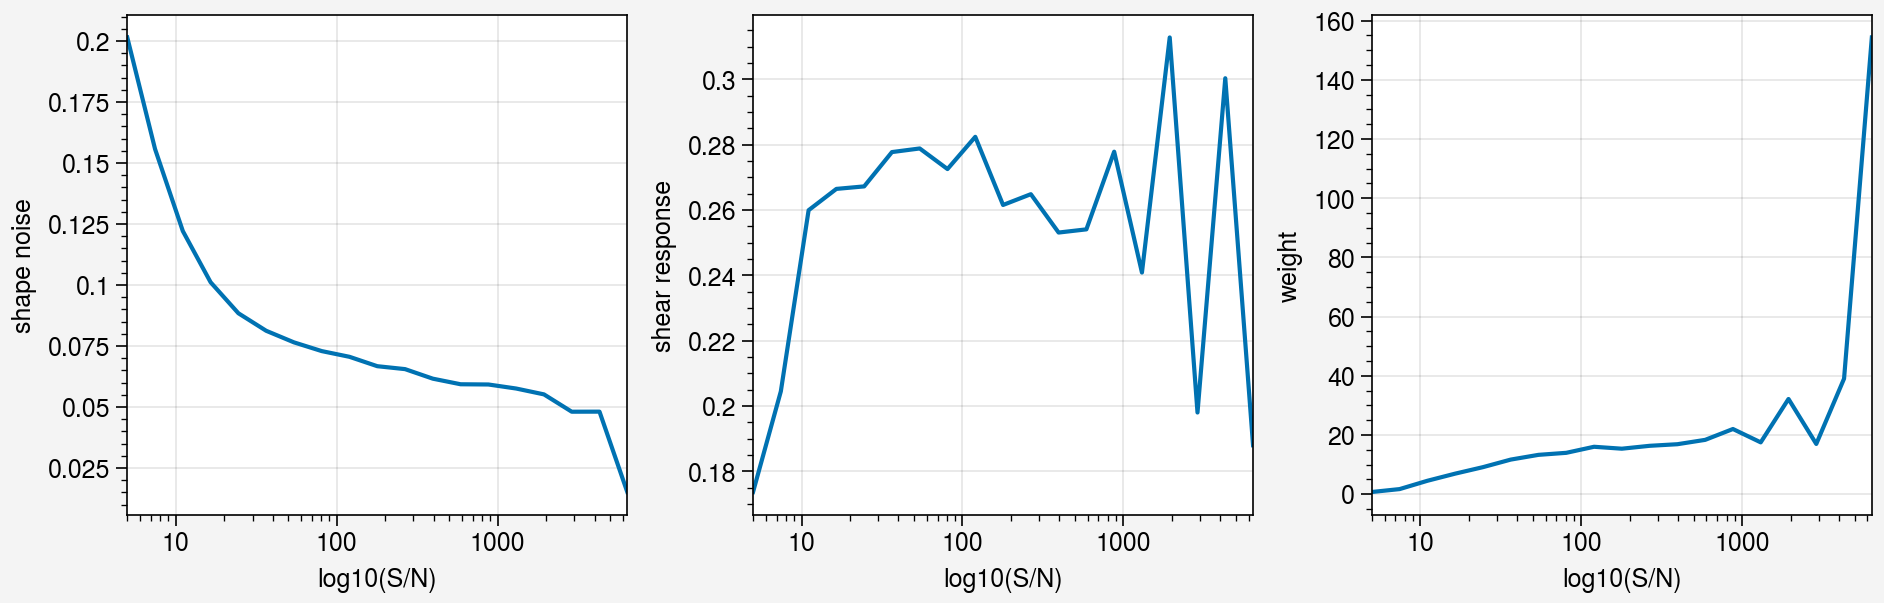

In [18]:
fig, axs = pplt.subplots(nrows=1, ncols=3, share=0)

axs[0].semilogx(10**bins_s2n[:-1], sn)
axs[0].format(xlabel="log10(S/N)", ylabel="shape noise")
axs[1].semilogx(10**bins_s2n[:-1], R)
axs[1].format(xlabel="log10(S/N)", ylabel="shear response")
axs[2].semilogx(10**bins_s2n[:-1], R**2/sn**2)
axs[2].format(xlabel="log10(S/N)", ylabel="weight")

In [43]:
wfunc = scipy.interpolate.interp1d(bins_s2n[:-1], R**2/sn**2, bounds_error=False, kind="linear")

In [52]:
msk_low = (np.log10(d["wmom_s2n"]) < bins_s2n[0])
msk_hi = (np.log10(d["wmom_s2n"]) > bins_s2n[-2])

wg = wfunc(np.log10(d["wmom_s2n"]))
wg[msk_low] = (R**2/sn**2)[0]
wg[msk_hi] = (R**2/sn**2)[-1]

assert not np.any(np.isnan(wg))

### do some stuff

In [53]:
w = 1.0/(0.07**2 + 0.5*d["wmom_g_cov_1_1"]**2 + 0.5*d["wmom_g_cov_2_2"]**2)

In [54]:
msk_v2 = des_y6utils.mdet.make_mdet_cuts(d, "2")

_comp_stats(d, msk_v2, w), _comp_stats(d, msk_v2, wg)

((772795, 0.3523954488990886, 0.28427978499471696, 1.5003093832748582),
 (772795, 0.29945872830980547, 0.24641111778742467, 1.381362183986154))

In [57]:
msk_agg = des_y6utils.mdet._make_mdet_cuts(
    d,
    min_s2n=10.0,
    min_t_ratio=1.5,
    n_terr=0,
    max_mfrac=0.1,
    max_s2n=1e3,
)

_comp_stats(d, msk_agg, w), _comp_stats(d, msk_agg, wg)

((248563, 0.37528083714033317, 0.09143638401378754, 2.967434671323842),
 (248563, 0.31820308684768933, 0.0782957212839087, 2.8218048282394252))

In [ ]:
msk_all = des_y6utils.mdet._make_mdet_cuts(
    d,
    min_s2n=5.0,
    min_t_ratio=1.1,
    n_terr=0.0,
    max_mfrac=0.1,
)

bins_tratio = np.linspace(np.log10(1.2), np.log10(np.max(d["wmom_T_ratio"][msk])), 4)
bins_s2n = np.linspace(np.log10(5), np.log10(np.max(d["wmom_s2n"][msk])), 4)


msk = msk_all & (d["mdet_step"] == "noshear")
n = np.histogram2d(
    np.log10(d["wmom_T_ratio"][msk]), 
    np.log10(d["wmom_s2n"][msk]), 
    bins=[bins_tratio, bins_s2n], 
    weights=np.ones(np.sum(msk)), 
    density=False,
)[0]

ne = np.histogram2d(
    np.log10(d["wmom_T_ratio"][msk]), 
    np.log10(d["wmom_s2n"][msk]), 
    bins=[bins_tratio, bins_s2n], 
    weights=d["wmom_g_1"][msk], 
    density=False,
)[0]

ne2 = np.histogram2d(
    np.log10(d["wmom_T_ratio"][msk]), 
    np.log10(d["wmom_s2n"][msk]), 
    bins=[bins_tratio, bins_s2n], 
    weights=d["wmom_g_1"][msk]**2, 
    density=False,
)[0]

msk = msk_all & (d["mdet_step"] == "1p")
n1p = np.histogram2d(
    np.log10(d["wmom_T_ratio"][msk]), 
    np.log10(d["wmom_s2n"][msk]), 
    bins=[bins_tratio, bins_s2n], 
    weights=np.ones(np.sum(msk)), 
    density=False,
)[0]

ne1p = np.histogram2d(
    np.log10(d["wmom_T_ratio"][msk]), 
    np.log10(d["wmom_s2n"][msk]), 
    bins=[bins_tratio, bins_s2n], 
    weights=d["wmom_g_1"][msk], 
    density=False,
)[0]

msk = msk_all & (d["mdet_step"] == "1m")
n1m = np.histogram2d(
    np.log10(d["wmom_T_ratio"][msk]), 
    np.log10(d["wmom_s2n"][msk]), 
    bins=[bins_tratio, bins_s2n], 
    weights=np.ones(np.sum(msk)), 
    density=False,
)[0]

ne1m = np.histogram2d(
    np.log10(d["wmom_T_ratio"][msk]), 
    np.log10(d["wmom_s2n"][msk]), 
    bins=[bins_tratio, bins_s2n], 
    weights=d["wmom_g_1"][msk], 
    density=False,
)[0]

In [ ]:
R = (ne1p/n1p - ne1m/n1m)/0.02

In [ ]:
sn = np.sqrt(ne2/n - (ne/n)**2)

In [ ]:
R

In [ ]:
R.shape

In [ ]:
sn.shape

In [ ]:
import scipy

In [ ]:
import scipy.interpolate

In [ ]:
wfunc = scipy.interpolate.RectBivariateSpline(bins_tratio[:-1], bins_s2n[:-1], 1.0/sn**2, s=0, kx=1, ky=1)

In [ ]:
wg = wfunc(np.log10(d["wmom_T_ratio"]), np.log10(d["wmom_s2n"]), grid=False)

In [ ]:
wg.min(), wg.max()

In [ ]:
w = 1.0/(0.14**2 + 0.5*d["wmom_g_cov_1_1"]**2 + 0.5*d["wmom_g_cov_2_2"]**2)

In [ ]:
msk_v2 = des_y6utils.mdet.make_mdet_cuts(d, "2")

In [ ]:
_comp_stats(d, msk_v2, wg)

In [ ]:
_comp_stats(d, msk_v2, w)

In [ ]:
msk_agg = des_y6utils.mdet._make_mdet_cuts(
    d,
    min_s2n=7.0,
    min_t_ratio=1.1,
    n_terr=0.0,
    max_mfrac=0.1,
)

_comp_stats(d, msk_agg, wg)

In [ ]:
print(sn_h12(d["wmom_g_1"][msk_hi])/R, sn_h12(d["wmom_g_1"][msk_hi], w=w[msk_hi])/Rw)
print(neff_h12(d["wmom_g_1"][msk_hi]), neff_h12(d["wmom_g_1"][msk_hi], w=w[msk_hi]))
print(prec_h12(d["wmom_g_1"][msk_hi], R), prec_h12(d["wmom_g_1"][msk_hi], Rw, w=w[msk_hi]))

In [ ]:
msk_all = des_y6utils.mdet.make_mdet_cuts(d_all, "2")

d_all = d_all[msk_all]

In [ ]:
msk = d_all["mdet_step"] == "noshear"

d = d_all[msk]

In [ ]:
w_all = prior.get_prob_array2d(d_all["wmom_g_1"], d_all["wmom_g_2"])
Rw = _compute_r(d_all, w=w_all)
R = _compute_r(d_all, w=None)
print(R, Rw)

In [ ]:
msk_low = (
    (d["wmom_T_ratio"] < 1.3)
    & (d["wmom_s2n"] > 100)
)

msk_hi = (
    (d["wmom_T_ratio"] > 1.5)
    & (d["wmom_s2n"] < 30)
)

w = prior.get_prob_array2d(d["wmom_g_1"], d["wmom_g_2"])

In [ ]:
prec = prec_h12(d["wmom_g_1"], R)
prec_w = prec_h12(d["wmom_g_1"], Rw, w=w)

In [ ]:
print(prec, prec_w, prec/prec_w)

In [ ]:
print(sn_h12(d["wmom_g_1"])/R, sn_h12(d["wmom_g_1"], w=w)/Rw)

In [ ]:
msks2n = d["wmom_s2n"] > 10*np.sqrt(6/4)

In [ ]:
print(sn_h12(d["wmom_g_1"][msks2n])/R, sn_h12(d["wmom_g_1"][msks2n], w=w[msks2n])/Rw)

In [ ]:
0.35/0.33

In [ ]:
np.sqrt(0.35**2 - 0.261**2)

In [ ]:
ms = np.sum(w * d["wmom_g_1"])/np.sum(w)

In [ ]:
g1 = d["wmom_g_1"] - ms

In [ ]:
sn_h12(g1, w=w)/Rw

In [ ]:
fig, axs = pplt.subplots(nrows=1, ncols=2, share=0)

axs[0].hist(d["wmom_g_1"][msk_hi], bins=25, density=True, log=True)
axs[1].hist(d["wmom_g_1"][msk_low], bins=25, density=True, log=True)

In [ ]:
w = prior.get_prob_array2d(d["wmom_g_1"], d["wmom_g_2"])

fig, axs = pplt.subplots(nrows=1, ncols=1, share=0)

axs[0].hist(d["wmom_g_1"], bins=50, density=True, log=True, color="b")
# axs[0].hist(d["wmom_g_1"], bins=50, density=True, log=True, alpha=0.5, color="r", weights=w)

In [ ]:
np.std?

In [ ]:
prior = ngmix.priors.GPriorBA(0.3, np.random.default_rng())